<a href="https://colab.research.google.com/github/hanklee97121/cs-497-group-1/blob/main/Copy_of_ESAM479_Individual_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install skccm

  Created wheel for skccm: filename=skccm-0.2.dev0-py3-none-any.whl size=12592 sha256=1656d552574a6491802243ebb720dcb11351c38c52b78830226ccd997d30c0b5
  Stored in directory: /root/.cache/pip/wheels/42/94/85/7f5c7ef2ce9a5a47e5d0d68d2c3a610225c81658cc5987b88c
Successfully built skccm


Individual Project: Comparison of CCM and GC test

1. Implement GC test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from google.colab import files
plt.rcParams.update({'font.size': 13})

from sklearn.linear_model import LinearRegression
import scipy


#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    print(np.var(x, ddof=1), np.var(y, ddof=1))
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p



def G_cau_test(variables, lag):
  '''
	variables: a list of np.adarray each array is a variable, for multiple variables we test causality of later variables on first variable
	Lag:number of past values for prediction
  '''
	#create data, data[i] is i-th variable, data[i][j] is lag-j of i-th variable
  data = []
  for var in variables:
    var_list = []
    for i in range(lag + 1):
      if i == 0:
        var_list.append(var)
      else:
        i_zeros = i * [0]
        var_new = i_zeros + var[:-i]
        var_list.append(var_new)
    data.append(var_list)
  
  #Use linear regression to predict variables
  #variable 1 on itself
  target_1 = data[0][0]
  feature_1 = np.stack(data[0][1:], axis = -1)
  # print(len(feature_1))
  # print(len)

  model_1 = LinearRegression()
  model_1.fit(feature_1, target_1)
  error_1 = target_1 - model_1.predict(feature_1)
  
  if len(variables) == 1:
    return "Only one variable detected"
  #print(error_1)
  #variable 1 on itself and rest variables
  feature_2 = []
  for i in range(0, len(variables)):
    for j in range(lag+1):
      feature_2.append(data[i][j])
  feature_2.pop(0)
  feature_3=np.stack(feature_2, axis = -1)
  
  model_2 = LinearRegression()
  model_2.fit(feature_3, target_1)
  error_2 = target_1 - model_2.predict(feature_3)
  #print(error_2)
  f, p = f_test(error_1, error_2)
  return f, p

2. Implement CMC test

In [ ]:
import matplotlib.pylab as pylab
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D
import skccm as ccm
from skccm.utilities import train_test_split
import seaborn as sns
sns.set()

In [ ]:
params = {'legend.fontsize': 'medium',
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

WIDTH, HEIGHT, DPI = 1000, 750, 100
s = 10
cmap = plt.cm.winter
cmap2 = plt.cm.summer

In [ ]:
def compute_mutual_info(x, y):
    e1 = ccm.Embed(x)
    e2 = ccm.Embed(y)
    max_lag = 50
    mutual_info_X = e1.mutual_information(max_lag)
    mutual_info_Y = e2.mutual_information(max_lag)

    fig, ax = plt.subplots(1,1, figsize=(5,3))
    fig.tight_layout()

    ax.plot(mutual_info_X)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Mutual Information of X')
    plt.savefig('mutual_info_x', bbox_inches="tight")
    plt.close()

    fig, ax = plt.subplots(1,1, figsize=(5,3))
    fig.tight_layout()

    ax.plot(mutual_info_Y)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Mutual Information of Y')
    plt.savefig('mutual_info_y', bbox_inches="tight")
    plt.close()

def forecast_skill(x, y, lag, embed):
    e1 = ccm.Embed(x)
    e2 = ccm.Embed(y)
    X_embd = e1.embed_vectors_1d(lag,embed)
    Y_embd = e2.embed_vectors_1d(lag,embed)
    xtr, xte, ytr, yte = train_test_split(X_embd,Y_embd, percent=.75)
    CCM = ccm.CCM()

    len_tr = len(xtr)
    lib_lens = np.arange(10, 100, dtype='int')

    #test causation
    CCM.fit(xtr,ytr)
    xp, yp = CCM.predict(xte, yte, lib_lengths=lib_lens)

    sc1, sc2 = CCM.score()
    print(sc1)
    print(sc2)

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.plot(lib_lens, sc1, '-', label = r'$\hat{X}(t)|M_Y$')
    ax.plot(lib_lens, sc2, '-', label = r'$\hat{Y}(t)|M_X$')

    ax.set_xlabel('Time series length L')
    ax.set_ylabel(r'Coefficient of Determination $R^2$')

    ax.legend()
    fig.tight_layout()
    plt.savefig('score_plot')
    plt.show()
    plt.close()



    yp1 = [yp[-1][i][0] for i in range(yp[0].shape[0])]
    yp2 = [yp[-1][i][1] for i in range(yp[0].shape[0])]
    #yp3 = [yp[-1][i][2] for i in range(yp[0].shape[0])]

    x1 = yp1
    y1 = yp2
    #z1 = yp3

    yte1 = [yte[i][0] for i in range(yte.shape[0])]
    yte2 = [yte[i][1] for i in range(yte.shape[0])]
    #yte3 = [yte[i][2] for i in range(yte.shape[0])]

    x2 = yte1
    y2 = yte2
    #z2 = yte3

    fig = plt.figure()#figsize=(WIDTH/DPI, HEIGHT/DPI))
    #ax = fig.gca(projection='3d')
    #fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    ax.plot(x1, y1, label='prediction')#, color=cmap(i/n), alpha=0.4)
    ax.legend()
    ax.set_axis_off()
    fig.tight_layout()
    plt.savefig('y_pred', dpi=DPI)
    plt.show()
    plt.close()

    fig = plt.figure()#figsize=(WIDTH/DPI, HEIGHT/DPI))
    #ax = fig.gca(projection='3d')
    ax.plot(x2, y2, label='ground truth')#, color=cmap2(i/n), alpha=0.4)
    ax.legend()
    ax.set_axis_off()
    fig.tight_layout()
    plt.savefig('y_test', dpi=DPI)
    plt.show()
    plt.close()


def sensitive_analysis(x, y, lag_list, embed_list):
    e1 = ccm.Embed(x)
    e2 = ccm.Embed(y)
    n_lag = len(lag_list)
    n_embed = len(embed_list)
    fig, ax = plt.subplots(2, n_embed, figsize=(40,15))
    for l in range(n_lag):
        for e in range(n_embed):
            lag = lag_list[l]
            embed = embed_list[e]
            sc1, sc2 = sensitive_analysis_helper(e1, e2, lag, embed)
            ax[0,e].plot(sc1, '-', label = r'$\tau=$' + '{}, '.format(lag))
            ax[1,e].plot(sc2, '-', label = r'$\tau=$' + '{}, '.format(lag))
            #ax[e,0].set_ylim(-0.5, 1.1)
            ax[0,e].set_xlabel('Time series length L')
            ax[0,e].set_ylabel(r'Coefficient of Determination $R^2$')
            ax[1,e].set_xlabel('Time series length L')
            ax[1,e].set_ylabel(r'Coefficient of Determination $R^2$')

            ax[0,e].set_title('E={}, '.format(embed) + r'$\hat{X}(t)|M_Y$')
            ax[0,e].legend()
            ax[1,e].set_title('E={}, '.format(embed) + r'$\hat{Y}(t)|M_X$')
            ax[1,e].legend()

    fig.tight_layout()
    plt.savefig('score_plot_sensitive_analysis2')
    plt.show()
    plt.close()


def sensitive_analysis_helper(e1, e2, lag, embed):

    X_embd = e1.embed_vectors_1d(lag,embed)
    Y_embd = e2.embed_vectors_1d(lag,embed)
    xtr, xte, ytr, yte = train_test_split(X_embd,Y_embd, percent=.75)
    CCM = ccm.CCM()

    len_tr = len(xtr)
    lib_lens = np.arange(10, len_tr, len_tr/100, dtype='int')

    #test causation
    CCM.fit(xtr,ytr)
    CCM.predict(xte, yte, lib_lengths=lib_lens)

    sc1, sc2 = CCM.score()

    return sc1, sc2

First system is normal AR(1) model, expectation is GC pass and CCM fail

mean of x1 =  0.2879479647824718 std of x1 =  1.0210789705807342
mean of y =  2.0557451636031177 std of y2 =  3.8099275048781216
8.909618100151253 4.251915742993208


(2.095436184226731, 0.00014144850154906852)

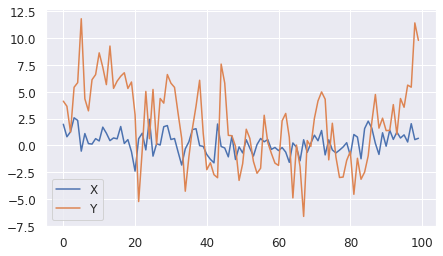

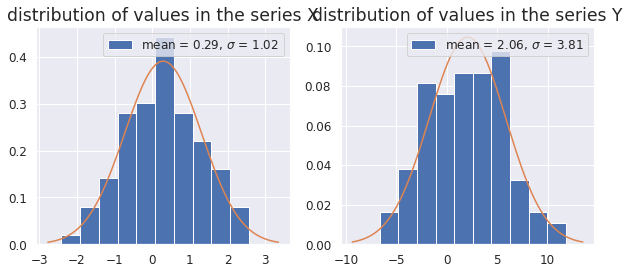

In [ ]:
# generate data for AR(1)
np.random.seed(0)
tlength = 100
X1 = np.zeros(tlength)
Y1 = np.zeros(tlength)

X1_beta_0 = 0.2
X1_beta_1 = 0.1
XY_beta1 = 2

Y1_beta_0 = 0.35
Y1_beta_1 = 0.5

x1_std = 1.
y1_std = 2.
x1_error = np.random.normal(0, x1_std, tlength)
y1_error = np.random.normal(0, y1_std, tlength)

X1[0] = x1_error[0] + X1_beta_0
Y1[0] = y1_error[0] + Y1_beta_0

# X1[0] = X1_beta_0
# Y1[0] = Y1_beta_0

for i in range(1, tlength):
  X1[i] = x1_error[i] + X1_beta_0 + X1_beta_1 * X1[i-1] 
  Y1[i] = y1_error[i] + Y1_beta_0 + Y1_beta_1 * Y1[i-1] + XY_beta1 * X1[i-1] 
  # X1[i] = X1_beta_0 + X1_beta_1 * X1[i-1] 
  # Y1[i] = Y1_beta_0 + Y1_beta_1 * Y1[i-1] + XY_beta1 * X1[i-1] 
  #Y1[i] = y1_error[i] + Y1_beta_0 + Y1_beta_1 * Y1[i-1]


tls = np.arange(0,tlength)

meanx1 = np.mean(X1)
meany1 = np.mean(Y1)

stdx1 = np.std(X1)
stdy1 = np.std(Y1)

fig0, ax0 = plt.subplots(figsize=(7, 4)) 
_ = ax0.plot(tls, X1, label = "X")
_ = ax0.plot(tls, Y1, label = "Y")
_ = ax0.legend()

fig, ax = plt.subplots(1,2, figsize = (10, 4))
ax[0].hist(X1, density = True, label=r'mean = %.2f, $\sigma$ = %.2f' %(meanx1, stdx1))
x = np.linspace(meanx1 - 3*stdx1, meanx1 + 3*stdx1, 100)
ax[0].plot(x, stats.norm.pdf(x, meanx1, stdx1))
ax[0].legend(loc = 'upper right')
ax[0].set_title('distribution of values in the series X')

ax[1].hist(Y1, density = True, label=r'mean = %.2f, $\sigma$ = %.2f' %(meany1, stdy1))
y = np.linspace(meany1 - 3*stdy1, meany1 + 3*stdy1, 100)
ax[1].plot(y, stats.norm.pdf(y, meany1, stdy1))
ax[1].legend(loc = 'upper right')
ax[1].set_title('distribution of values in the series Y')
plt.savefig('ar1_dist.png')
#files.download('ar1_dist.png') 
print("mean of x1 = ", meanx1, "std of x1 = ", stdx1)
print("mean of y = " ,meany1, "std of y2 = ", stdy1)

X1ls = X1.tolist()
Y1ls = Y1.tolist()
G_cau_test([Y1ls, X1ls], 1)

In [ ]:
#perform CCM test on X and Y
compute_mutual_info(X1, Y1)

[-0.996516261383199, -0.9964194343031224, -0.9963184930369573, -0.9962131999467279, -0.9961032998953734, -0.9959885186687176, -0.995868561228589, -0.99574310977513, -0.9956118215943583, -0.9954743266628961, -0.9953302249782722, -0.9951790835776728, -0.9950204332027491, -0.9948537645614023, -0.994678524129476, -0.9944941094261004, -0.994299863685065, -0.9940950698323198, -0.99387894366293, -0.9936506260930381, -0.9934091743392616, -0.9931535518513617, -0.9928826167903765, -0.9925951088054085, -0.9922896338127181, -0.991964646421529, -0.9916184295771286, -0.9912490709008974, -0.9908544350936326, -0.9904321316271473, -0.9899794767710265, -0.9894934487767069, -0.9889706347548042, -0.9884071674152478, -0.9877986493674437, -0.9871400620642248, -0.9864256556705282, -0.9856488150782855, -0.9848018958788355, -0.983876022209289, -0.9828608358177059, -0.9817441821642005, -0.9805117144797897, -0.9791463898264702, -0.9776278214071032, -0.9759314372204502, -0.97402737438039, -0.9718790073882371, -0.

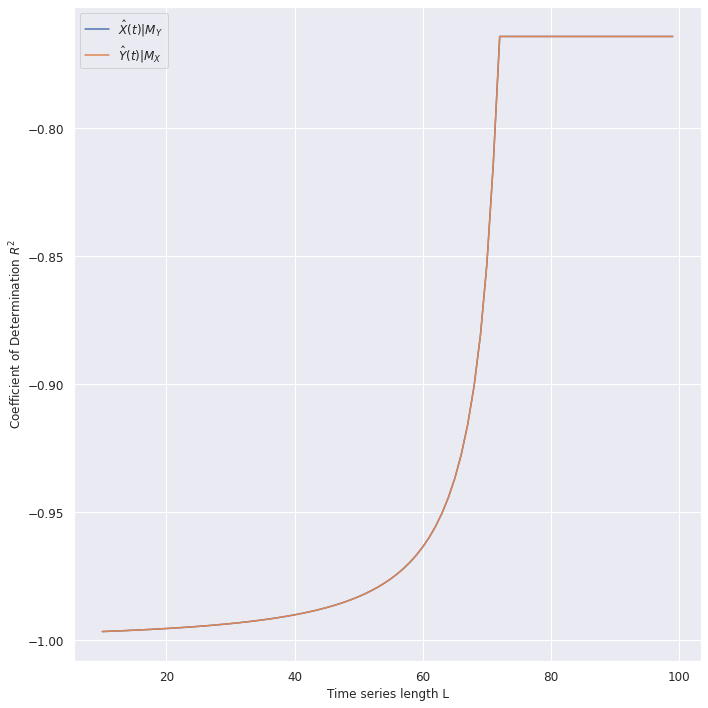

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
lag = 1
embed = 5
forecast_skill(x, y, lag, embed)

System 2: AR(2) that GC fails

mean of x1 =  1.3514105864889051e+21 std of x1 =  6.703675147261504e+21
mean of y =  9.920586853313121e+20 std of y2 =  4.92110926166334e+21
76585004826.44865 827041254873.8417


(0.09260119053931724, 1.0)

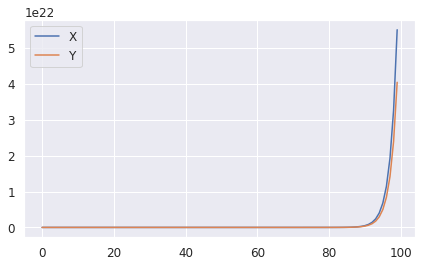

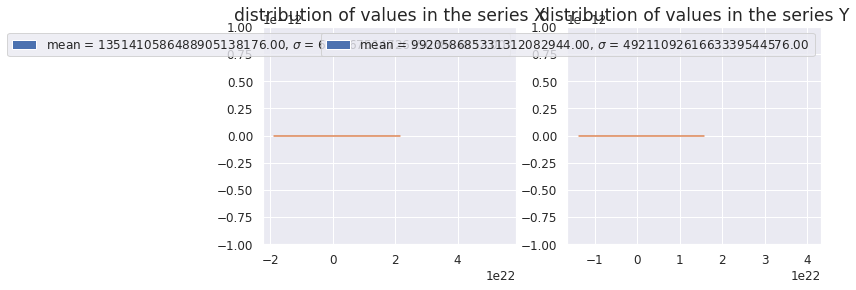

In [ ]:
# generate data for AR(2)
np.random.seed(1)
tlength = 100
X1 = np.zeros(tlength)
Y1 = np.zeros(tlength)

X1_beta_0 = 1
X1_beta_1 = 0.8
X1_beta_2 = 1.5
XY_beta1 = 1

Y1_beta_0 = 1.5
Y1_beta_1 = 0.8
Y1_beta_2 = -0.8

x1_std = 0.1
y1_std = 2.
x1_error = np.random.normal(0, x1_std, tlength)
y1_error = np.random.normal(0, y1_std, tlength)

X1[0] = x1_error[0] + X1_beta_0
Y1[0] = y1_error[0] + Y1_beta_0

X1[1] = X1_beta_0 + X1_beta_1*X1[0] + x1_error[1]
Y1[1] = Y1_beta_0 + Y1_beta_1*Y1[0] + y1_error[1]

for i in range(2, tlength):
  X1[i] = x1_error[i] + X1_beta_0 + X1_beta_1 * X1[i-1] + X1_beta_2 * X1[i-2]
  Y1[i] = y1_error[i] + Y1_beta_0 + Y1_beta_1 * Y1[i-1] + Y1_beta_2 * Y1[i-2] + XY_beta1 * X1[i-1] 
  # X1[i] = X1_beta_0 + X1_beta_1 * X1[i-1] 
  # Y1[i] = Y1_beta_0 + Y1_beta_1 * Y1[i-1] + XY_beta1 * X1[i-1] 
  #Y1[i] = y1_error[i] + Y1_beta_0 + Y1_beta_1 * Y1[i-1]


tls = np.arange(0,tlength)

meanx1 = np.mean(X1)
meany1 = np.mean(Y1)

stdx1 = np.std(X1)
stdy1 = np.std(Y1)

fig0, ax0 = plt.subplots(figsize=(7, 4)) 
_ = ax0.plot(tls, X1, label = "X")
_ = ax0.plot(tls, Y1, label = "Y")
_ = ax0.legend()

fig, ax = plt.subplots(1,2, figsize = (10, 4))
ax[0].hist(X1, density = True, label=r'mean = %.2f, $\sigma$ = %.2f' %(meanx1, stdx1))
x = np.linspace(meanx1 - 3*stdx1, meanx1 + 3*stdx1, 100)
ax[0].plot(x, stats.norm.pdf(x, meanx1, stdx1))
ax[0].legend(loc = 'upper right')
ax[0].set_title('distribution of values in the series X')

ax[1].hist(Y1, density = True, label=r'mean = %.2f, $\sigma$ = %.2f' %(meany1, stdy1))
y = np.linspace(meany1 - 3*stdy1, meany1 + 3*stdy1, 100)
ax[1].plot(y, stats.norm.pdf(y, meany1, stdy1))
ax[1].legend(loc = 'upper right')
ax[1].set_title('distribution of values in the series Y')
plt.savefig('ar1_dist.png')
#files.download('ar1_dist.png') 
print("mean of x1 = ", meanx1, "std of x1 = ", stdx1)
print("mean of y = " ,meany1, "std of y2 = ", stdy1)

X1ls = X1.tolist()
Y1ls = Y1.tolist()
G_cau_test([Y1ls, X1ls], 2)

In [ ]:
#perform CCM test on X and Y
compute_mutual_info(X1, Y1)

[-0.37166734781131017, -0.37164647647622684, -0.43879956428784606, -0.43920034109736894, -0.4498514900139502, -0.4689204231080259, -0.5022812065858641, -0.5429838864913419, -0.6247466941115536, -0.6935664656544448, -0.7608228115605016, -0.780210293240012, -0.8810546720948705, -0.9089448294179536, -0.9594827180682938, -0.9921985018454281, -0.9883765741140396, -0.9773037592495782, -0.968312406333357, -0.9238114218863661, -0.8075741832733208, -0.19423333333648313, -0.19423195831302756, -0.19423095424613074, -0.19423086638530412, -0.19423079781184077, -0.19423077560234822, -0.1942309456737648, -0.19423089049973546, -0.19423087624957835, -0.1942308736312615, -0.19423086861486394, -0.1942308697446294, -0.19423086565781003, -0.19423086235566264, -0.19423085489598085, -0.19423084055003148, -0.19423081506293602, -0.19423077247838982, -0.1942307007777065, -0.19423057965788718, -0.1942303751659436, -0.19423003006295375, -0.1942294473759994, -0.19422846353827078, -0.19422680235700723, -0.194223997

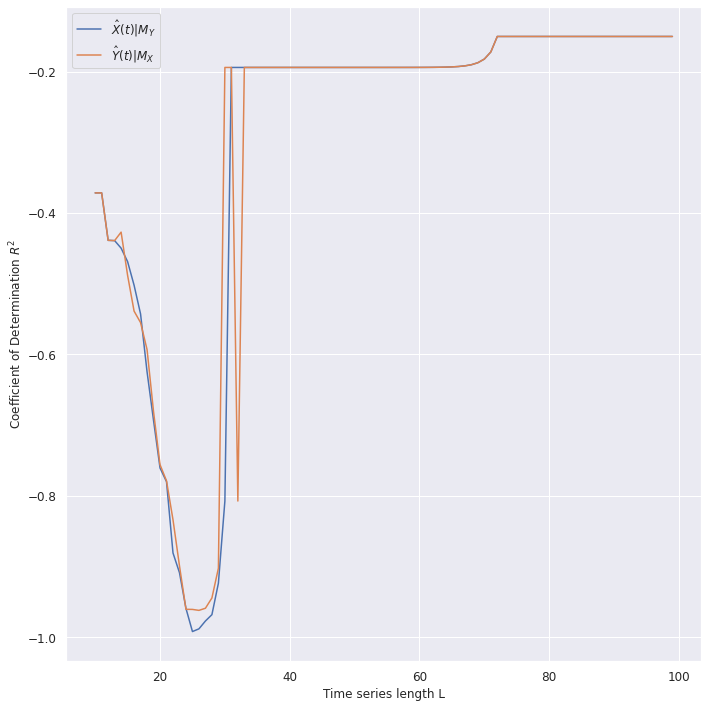

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
lag = 1
embed = 5
forecast_skill(X1, Y1, lag, embed)

System 3: asymmetric coupled system

In [ ]:
import skccm.data as data

rx1 = 3.72 #determines chaotic behavior of the x1 series
rx2 = 3.72 #determines chaotic behavior of the x2 series
b12 = 0.2 #Influence of x1 on x2
b21 = 0.01 #Influence of x2 on x1
ts_length = 1000
x1,x2 = data.coupled_logistic(rx1,rx2,b12,b21,ts_length)

Text(0.5, 1.0, 'X')

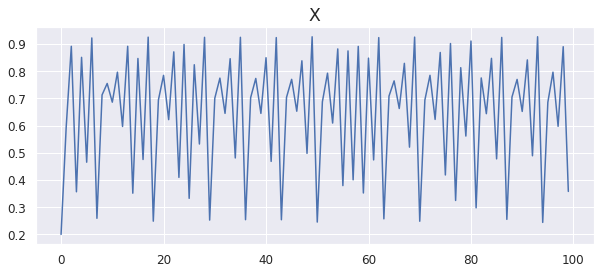

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(x1[:100])
ax.set_title("X")

Text(0.5, 1.0, 'Y')

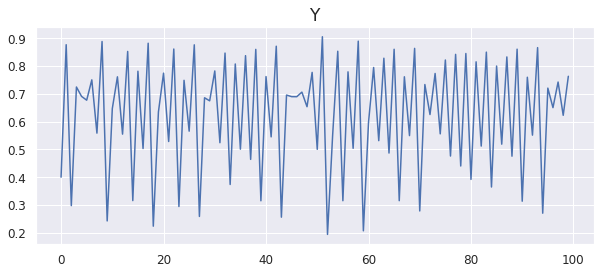

In [ ]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(x2[:100])
ax.set_title("Y")

In [ ]:
X = x1.tolist()
Y = x2.tolist()
G_cau_test([X, Y], 1)

0.022189913887400433 0.02178482702749009


(1.0185949082542252, 0.3854910243484202)

In [ ]:
#perform CCM test on X and Y
compute_mutual_info(x1, x2)

[-0.14357465144285192, -0.14021658212589938, -0.14789987603066088, -0.16783633673150675, -0.18182749082067118, -0.1661403712038766, -0.173252670205761, -0.1792653191267993, -0.11070599191234934, -0.07181561140484677, -0.06580517335947839, -0.03966421525934978, -0.03531885990481631, -0.029159748966389662, -0.014957880012621749, -0.016029314339229755, -0.013296304768705282, -0.004016255188693637, 0.013824765780403793, 0.017039827352319303, 0.016745647365527385, 0.05519399770015342, 0.11746906307739913, 0.18516680209267433, 0.30987423111136414, 0.40718114718553877, 0.4650668365746813, 0.49252563705298436, 0.48989848911808326, 0.49967323349930026, 0.5091411159574313, 0.505379298627531, 0.5079982956940025, 0.5291863237544601, 0.5410635987141827, 0.5389077496026613, 0.5411297607423629, 0.5406858160615774, 0.5365906243182899, 0.5374579695119766, 0.5486330233165553, 0.5560361294384126, 0.5569149470664535, 0.5535744136870564, 0.5406180400813694, 0.5299129538516725, 0.5189735323274773, 0.5190099

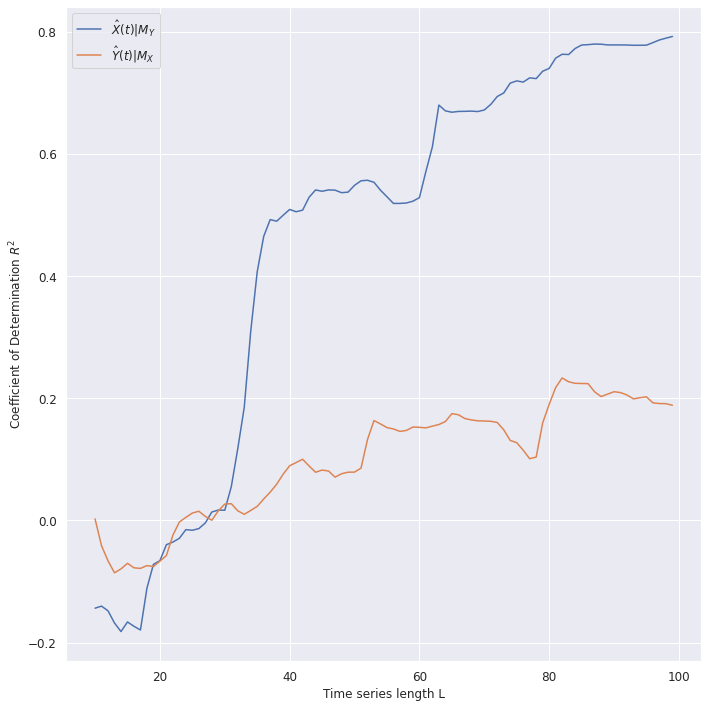

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
lag = 1
embed = 2
forecast_skill(x1, x2, lag, embed)

system 4: Linear System that CCM fails

mean of x1 =  0.0011211029622248162 std of x1 =  0.7083789357230105
mean of y =  0.10382730571674932 std of y2 =  3.156502513801243
8.236055890801405 6.487526937089778


(1.2695216483364606, 8.296057394363565e-05)

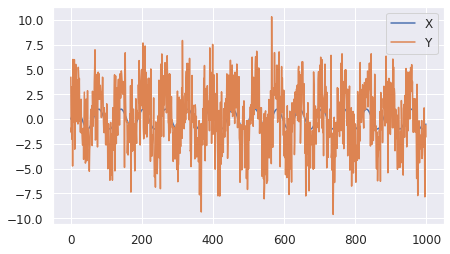

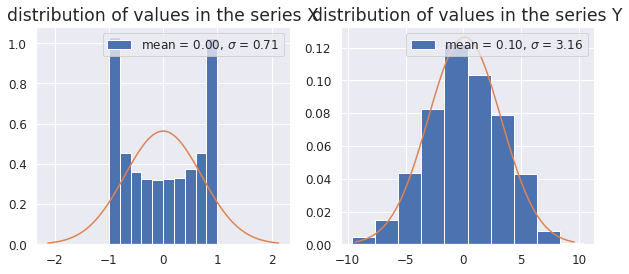

In [ ]:
# generate data for AR(2)
np.random.seed(1)
tlength = 1000
t = np.linspace(0, 100, tlength)
X1 = np.sin(t)
Y1 = np.zeros(tlength)

Y1_beta_0 = 2.6
Y1_beta_1 = 2.6



y1_std = 1.

y1_error = np.random.normal(0, y1_std, tlength)

for i in range(tlength):
  
  Y1[i] = Y1_beta_0*X1[i] + Y1_beta_1*y1_error[i] 
  # X1[i] = X1_beta_0 + X1_beta_1 * X1[i-1] 
  # Y1[i] = Y1_beta_0 + Y1_beta_1 * Y1[i-1] + XY_beta1 * X1[i-1] 
  #Y1[i] = y1_error[i] + Y1_beta_0 + Y1_beta_1 * Y1[i-1]


tls = np.arange(0,tlength)

meanx1 = np.mean(X1)
meany1 = np.mean(Y1)

stdx1 = np.std(X1)
stdy1 = np.std(Y1)

fig0, ax0 = plt.subplots(figsize=(7, 4)) 
_ = ax0.plot(tls, X1, label = "X")
_ = ax0.plot(tls, Y1, label = "Y")
_ = ax0.legend()

fig, ax = plt.subplots(1,2, figsize = (10, 4))
ax[0].hist(X1, density = True, label=r'mean = %.2f, $\sigma$ = %.2f' %(meanx1, stdx1))
x = np.linspace(meanx1 - 3*stdx1, meanx1 + 3*stdx1, 100)
ax[0].plot(x, stats.norm.pdf(x, meanx1, stdx1))
ax[0].legend(loc = 'upper right')
ax[0].set_title('distribution of values in the series X')

ax[1].hist(Y1, density = True, label=r'mean = %.2f, $\sigma$ = %.2f' %(meany1, stdy1))
y = np.linspace(meany1 - 3*stdy1, meany1 + 3*stdy1, 100)
ax[1].plot(y, stats.norm.pdf(y, meany1, stdy1))
ax[1].legend(loc = 'upper right')
ax[1].set_title('distribution of values in the series Y')
plt.savefig('ar1_dist.png')
#files.download('ar1_dist.png') 
print("mean of x1 = ", meanx1, "std of x1 = ", stdx1)
print("mean of y = " ,meany1, "std of y2 = ", stdy1)

X1ls = X1.tolist()
Y1ls = Y1.tolist()
G_cau_test([Y1ls, X1ls], 2)

In [ ]:
#perform CCM test on X and Y
compute_mutual_info(X1, Y1)

[0.5745922183660748, 0.5867931383905933, 0.45959877008826994, 0.5017800676128197, 0.5084396763745005, 0.537700195367097, 0.5235038641819885, 0.5206005395860069, 0.5205310028856849, 0.5347644762040149, 0.5626301554312592, 0.5651886214505822, 0.5610361339614837, 0.5526453569012605, 0.5348369775242832, 0.5312430987143828, 0.5518501384205989, 0.5467643304065248, 0.5554160531977688, 0.5551149792422467, 0.5283798524174717, 0.5609809256681864, 0.5818913078273846, 0.6066494425027905, 0.6253522448679218, 0.6380208700193349, 0.6546927986963718, 0.6687072751718194, 0.6488410522444719, 0.6462091968640237, 0.6503709588882505, 0.654965746684842, 0.6531654355193954, 0.6759739850461034, 0.6555027825856959, 0.6577383345313508, 0.6610021895344493, 0.643213556123202, 0.6098887007620162, 0.6157555761552005, 0.6097269065189626, 0.6190001910042096, 0.6182071017808405, 0.6184458400740671, 0.622223788931442, 0.6271100076247464, 0.6271790115984874, 0.6316950136406916, 0.6271836827957955, 0.6294820984654421, 0.

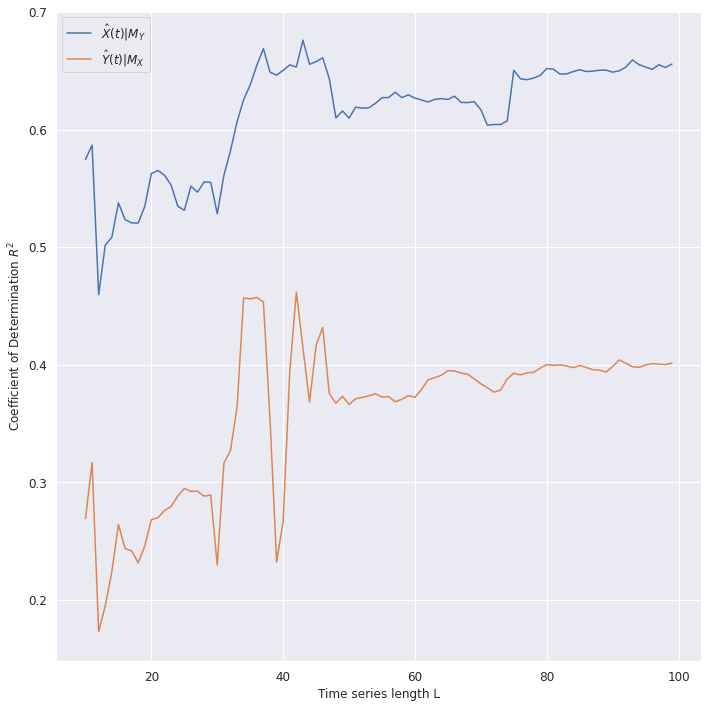

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
lag = 1
embed = 2
forecast_skill(X1, Y1, lag, embed)